In [1]:
import pandas as pd
import json
from glob import glob
from sklearn.model_selection import train_test_split

In [2]:
def json_to_dataframe(file_path):
    return pd.read_json(file_path, lines=True)

def merge_jsonl_to_dataframe(file_pattern):
    files = glob(file_pattern)
    dfs = [json_to_dataframe(file) for file in files]
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

file_pattern = "data/*.jsonl"
df = merge_jsonl_to_dataframe(file_pattern)

#  Preprocessing

In [3]:
# Creating the answers_df
human_df = pd.DataFrame({'questions': df['question'], 'answers': df['human_answers'], 'is_human': 1 })
gpt_df = pd.DataFrame({'questions': df['question'], 'answers': df['chatgpt_answers'], 'is_human': 0})
answers_df = pd.concat([human_df, gpt_df], axis=0, ignore_index=True)

# Cleaning
answers_df = answers_df.explode('answers', ignore_index=True)
answers_df = answers_df.dropna(subset=['answers'], ignore_index=True)
answers_df = answers_df[~answers_df['answers'].str.endswith('There was an error generating a response')]
answers_df = answers_df[~answers_df['answers'].str.endswith('Log out')]
deprecated_df = answers_df[~answers_df['answers'].str.len() == 0]

# Importing other_df
csv = pd.read_csv("data/hack_train.csv")
csvFull = csv.rename(columns={'text': 'answers', "label" : "is_human"})
newly_df = csvFull.drop(columns="src")

deprecated_df.head()
newly_df.head()

,answers,is_human
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1


In [4]:
X = newly_df['answers']
y = newly_df['is_human']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

# Logistic Regression

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

Accuracy:  0.8584125307990145


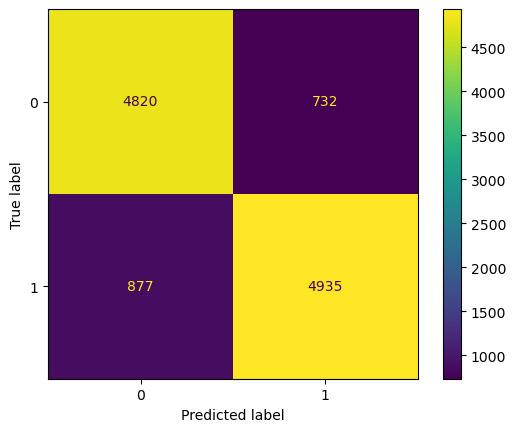

In [6]:

model = make_pipeline(TfidfVectorizer(max_features=10000,ngram_range=(1,2)), 
LogisticRegression(C=10, random_state=42, class_weight='balanced', penalty='l2', max_iter=10000))
model.fit(X_train.values, y_train)
evaluate_model(model, X_test, y_test)